# Multi-armed Bandits

Consider the following learning problem. You are faced repeatedly with a choice among k different options, or actions. After each choice you receive a numerical reward chosen from a stationary probability distribution that depends on the action you selected.

Your objective is to maximize the expected total reward over some time period, for example, over 1000 action selections, or time steps.

This is the original form of the k-armed bandit problem, so named by analogy to a slot machine, or “one-armed bandit,” except that it has k levers instead of one.

Another analogy is that of a doctor choosing between experimental treatments for a series of seriously ill patients. Each action is the selection of a treatment, and each reward is the survival or well-being of the patient.

We denote the action selected on time step t as $A_t$, and the corresponding reward as $R_t$. The value then of an arbitrary action a, denoted $q^*(a)$, is the expected reward given that a is selected:

$$ q^*(a) = \mathbb{E}[R_t|A_t = a] $$

If you knew the value of each action, then it would be trivial to solve the k-armed bandit problem.

We denote the estimated value of action a at time step $t$ as $Q_t(a)$. We would like $Q_t(a)$ to be close to $q^*(a)$.

When you select one of these actions, we say that you are ***exploiting*** your current knowledge of the values of the actions. If instead you select one of the nongreedy actions, then we say you are ***exploring***, because this enables you to improve your estimate of the nongreedy action’s value.

## Action-value Methods

One natural way to estimate the true value of an action is by **averaging** the rewards actually received:

$$ 
Q_t(a) \space \dot{=} 
\space \frac{\text{sum of rewards when $a$ taken prior to $t$}}{\text{number of times $a$ taken prior to $t$}}
 = \frac{\sum_{t=1}^{t-1} R_i . \mathbb{1}_{A_i = a}}{\sum_{t=1}^{t-1} \mathbb{1}_{A_i = a}}
$$

where $\mathbb{1}_{predicate}$ denotes the random variable that is 1 if predicate is true and 0 if it is not.

As the denominator goes to infinity, by the law of large numbers, $Q_t(a)$ converges to $q^*(a)$. We call this the ***sample-average*** method for estimating action values because each estimate is an average of the sample of relevant rewards.

The simplest action selection rule is to select one of the actions with the highest estimated value.

$$ A_t \space \dot{=} \space \underset{a}{\mathrm{argmax}} \space Q_t(a) $$

### $\varepsilon$-Greedy Action Selection

Greedy action selection always exploits current knowledge to maximize immediate reward; it spends no time at all sampling apparently inferior actions to see if they might really be better. A simple alternative is to behave *greedily* most of the time, but every once in a while, say with small probability $\varepsilon$, instead select randomlyfrom among all the actions with equal probability, independently of the action-value estimates. We call methods using this near-greedy action selection rule ***$\varepsilon$-greedy*** methods.

## The 10-armed Testbed

This is a set of 2000 randomly generated k-armed bandit problems with k = 10. For each bandit problem, the action values, $q^*(a)$, $a = 1, ... , 10$, are selected according to a normal (Gaussian) distribution with mean 0 and variance 1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
k = 10
num_problems = 2000

q_star = np.random.normal(0, 1, (num_problems,k))
arms = [0] * k

for i in range(10):
    arms[i] = np.random.normal(q_star[0, i], 1, 2000) # first problem as a sample

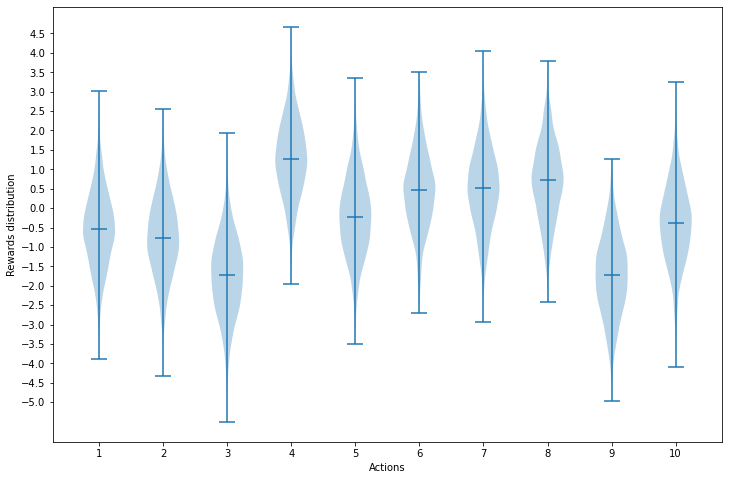

In [3]:
plt.figure(figsize=(12,8))
plt.ylabel('Rewards distribution')
plt.xlabel('Actions')
plt.xticks(range(1,11))
plt.yticks(np.arange(-5,5,0.5))

plt.violinplot(arms, positions=range(1,11), showmedians=True)
plt.show()

The true value $q^*(a)$ of each of the ten actions was selected according to a normal distribution with mean zero and unit variance, and then the actual rewards were selected according to a mean $q^*(a)$, unit-variance normal distribution, as suggested by these blue distributions.

## Incremental Implementation

It is easy to devise incremental formulas for updating averages with small, constant computation required to process each new reward. Given $Q_n$ and the $n$th reward, $R_n$, the new average of all n rewards can be computed by

$$ Q_{n+1} = Q_n + \frac{1}{n} [R_n - Q_n] $$

This implementation requires memory only for Qn and n, and only the small computation for each new reward.

Code for a complete bandit algorithm using incrementally computed sample averages and $\varepsilon$-greedy action selection is shown in the box below. The function **bandit(a)** is assumed to take an action and return a corresponding reward.

In [4]:
def bandit(action, problem):
    return np.random.normal(q_star[problem, action], 1)

In [5]:
def simple_max(Q, N, t):
#     return np.argmax(Q)
    return np.random.choice(np.flatnonzero(Q == Q.max())) # breaking ties randomly

In [6]:
def simple_bandit(k, epsilon, steps, initial_Q, alpha=0, argmax_func=simple_max):
    rewards = np.zeros(steps)
    actions = np.zeros(steps)
    
    for i in tqdm(range(num_problems)):
        Q = np.ones(k) * initial_Q # initial Q
        N = np.zeros(k)  # initalize number of rewards given
        best_action = np.argmax(q_star[i])
        for t in range(steps):
            if np.random.rand() < epsilon: # explore
                a = np.random.randint(k)
            else: # exploit
                a = argmax_func(Q, N, t)

            reward = bandit(a, i)

            N[a] += 1
            if alpha > 0:
                Q[a] = Q[a] + (reward - Q[a]) * alpha
            else:
                Q[a] = Q[a] + (reward - Q[a]) / N[a]

            rewards[t] += reward
            
            if a == best_action:
                actions[t] += 1
    
    return np.divide(rewards,num_problems), np.divide(actions,num_problems)

In [7]:
ep_0, ac_0 = simple_bandit(k=10, epsilon=0, steps=1000, initial_Q=0)
ep_01, ac_01 = simple_bandit(k=10, epsilon=0.01, steps=1000, initial_Q=0)
ep_1, ac_1 = simple_bandit(k=10, epsilon=0.1, steps=1000, initial_Q=0)

100%|██████████| 2000/2000 [00:45<00:00, 43.56it/s]


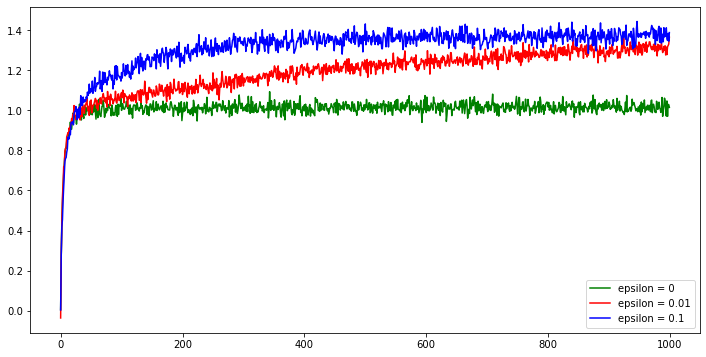

In [8]:
plt.figure(figsize=(12,6))
plt.plot(ep_0, 'g', label='epsilon = 0')
plt.plot(ep_01, 'r', label='epsilon = 0.01')
plt.plot(ep_1, 'b', label='epsilon = 0.1')
plt.legend() 
plt.show()

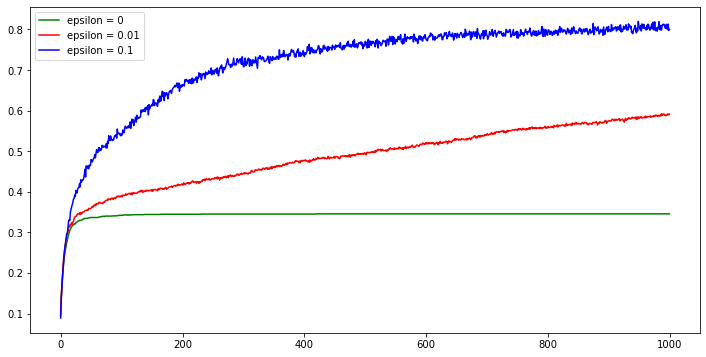

In [9]:
plt.figure(figsize=(12,6))
plt.yticks(np.arange(0,1,0.1))
plt.plot(ac_0, 'g', label='epsilon = 0')
plt.plot(ac_01, 'r', label='epsilon = 0.01')
plt.plot(ac_1, 'b', label='epsilon = 0.1')
plt.legend() 
plt.show()

## Nonstationary Problem

we often encounter reinforcement learning problems that are effectively nonstationary. In such cases it makes sense to give more weight to recent rewards than to long-past rewards. One of the most popular ways of doing this is to use a constant step-size parameter.

$$ Q_{n+1} \space \dot{=} \space Q_n + \alpha \space [R_n - Q_n] $$

This results in $Q_{n+1}$ being a weighted average of past rewards and the initial estimate $Q_1$:

$$ Q_{n+1} = (1-\alpha)^n Q_1 + \sum_{i=1}^{n} \alpha (1-\alpha)^{n-i} R_i $$

We call this a weighted average because the sum of the weights is $ (1-\alpha)^n + \sum_{i=1}^{n} \alpha (1-\alpha)^{n-i} = 1 $.

The weight decays exponentially according to the exponent on $1-\alpha$. Accordingly, this is sometimes called an ***exponential recency-weighted average***.

### Step-Size Parameter

Sometimes it is convenient to vary the step-size parameter from step to step. Let $\alpha_n(a)$ denote the step-size parameter used to process the reward received after the $n$th selection of action $a$.

A well-known result in stochastic approximation theory gives us the conditions required to assure convergence with probability 1:

$$ \text{(1)}\space \sum_{n=1}^{\infty}\alpha_n(a) = \infty $$

The first condition is required to guarantee that the steps are large enough to eventually overcome any initial conditions or random fluctuations.

$$ \text{(2)}\space \sum_{n=1}^{\infty}\alpha_n(a)^2 < \infty $$

The second condition guarantees that eventually the steps become small enough to assure convergence.

Note that both convergence conditions are met for the sample-average case, $\alpha_n(a) = \frac{1}{n}$ , but not for the case of constant step-size parameter, $\alpha_n(a) = \alpha$.

In the latter case, the second condition is not met, indicating that the estimates never completely converge but continue to vary in response to the most recently received rewards. As we mentioned above, this is actually desirable in a nonstationary environment, and problems that are effectively nonstationary are the most common in reinforcement learning.

## Optimistic Initial Values

Initial action values can also be used as a simple way to encourage exploration.

Suppose that instead of setting the initial action values to zero, as we did in the 10-armed testbed, we set them all to $+5$. An initial estimate of $+5$ is wildly optimistic and this optimism encourages action-value methods to explore. 

In [10]:
opt_0, ac_opt_0 = simple_bandit(k=10, epsilon=0, steps=1000, initial_Q=5, alpha=0.2)

100%|██████████| 2000/2000 [00:49<00:00, 40.71it/s]


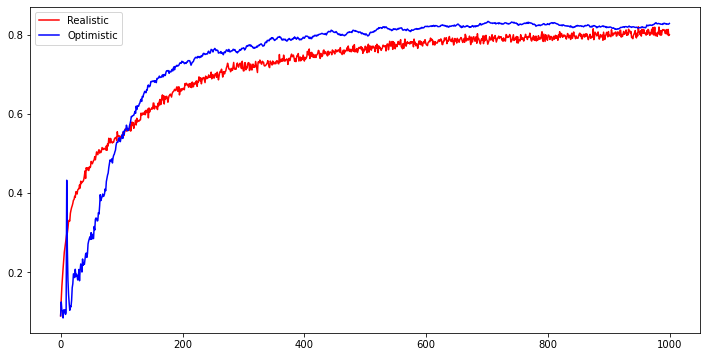

In [11]:
plt.figure(figsize=(12,6))
plt.yticks(np.arange(0,3,0.2))
plt.plot(ac_1, 'r', label='Realistic')
plt.plot(ac_opt_0, 'b', label='Optimistic')
plt.legend() 
plt.show()

Initially, the optimistic method performs worse because it explores more, but eventually it performs better because its exploration decreases with time. We call this technique for encouraging exploration optimistic initial values. We regard it as a simple trick that can be quite effective on stationary problems, but it is far from being a generally useful approach to encouraging exploration.

## Upper-Confidence-Bound Action Selection

Exploration is needed because there is always uncertainty about the accuracy of the action-value estimates. $\varepsilon$-greedy action selection forces the non-greedy actions to be tried, but indiscriminately, with no preference for those that are nearly greedy or particularly uncertain. 
It would be better to select among the non-greedy actions according to their potential for actually being optimal, taking into account both how close their estimates are to being maximal and the uncertainties in those estimates.

One effective way of doing this is to select actions according to

$$ A_t \space \dot{=} \space \underset{a}{\mathrm{argmax}} \space \left[Q_t(a) + c \space \sqrt{\frac{\ln t}{N_t(a)}} \right] $$ 

The idea of this ***upper confidence bound*** (UCB) action selection is that the square-root term is a measure of the uncertainty or variance in the estimate of $a$’s value. The quantity being max’ed over is thus a sort of upper bound on the possible true value of action a, with c determining the confidence level. 

In [12]:
def ucb(Q, N, t):
    c = 2
    if N.min() == 0:
        return np.random.choice(np.flatnonzero(N == N.min()))
    
    M = Q + c * np.sqrt(np.divide(np.log(t),N))
    return np.argmax(M) # breaking ties randomly

If $N_t(a) = 0$, then a is considered to be a maximizing action.

In [13]:
ucb_2, ac_ucb_2 = simple_bandit(k=10, epsilon=0, steps=1000, initial_Q=0, argmax_func=ucb)

100%|██████████| 2000/2000 [00:46<00:00, 42.99it/s]


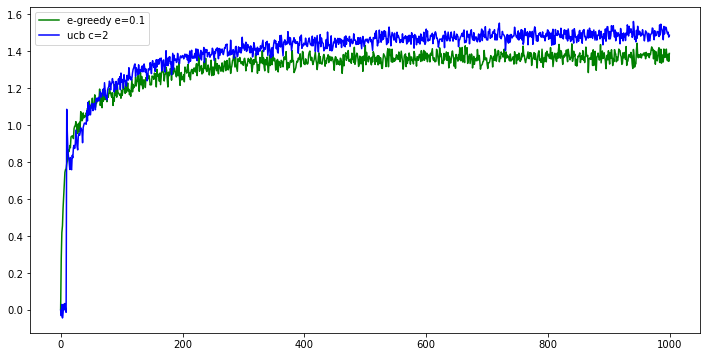

In [14]:
plt.figure(figsize=(12,6))
plt.plot(ep_1, 'g', label='e-greedy e=0.1')
plt.plot(ucb_2, 'b', label='ucb c=2')
plt.legend() 
plt.show()

UCB often performs well, as shown here, but is more difficult than $\varepsilon$-greedy to extend beyond bandits to the more general reinforcement learning settings.
One difficulty is in dealing with nonstationary problems, another difficulty is dealing with large state spaces.

## Gradient Bandit Algorithms

We consider learning a numerical _preference_ for each action $a$, which we denote $H_t(a) \in {\rm I\!R}$.

The larger the preference, the more often that action is taken, but the preference has no interpretation in terms of reward. Only the relative preference of one action over another is important.

Action probabilities are determined according to a soft-max distribution (i.e., Gibbs or Boltzmann distribution) as follows:

$$ Pr\{ A_t = a\} \space \dot{=} \space \frac{e^{H_t(a)}}{\sum_{b=1}^{k}e^{H_t(b)}} \space \dot{=} \space  \pi_t(a)$$

There is a natural learning algorithm for soft-max action preferences based on the idea of stochastic gradient ascent. On each step, after selecting action $A_t$ and receiving the reward $R_t$, the action preferences are updated by:

$$ H_{t+1}(A_t) = H_t(A_t) + \alpha\space(R_t - \bar{R_t})(1 - \pi_t(A_t)) $$ and,
$$ H_{t+1}(a) = H_t(a) + \alpha\space(R_t - \bar{R_t})\pi_t(a) $$ for all $a \neq A_t$

where $\alpha > 0$ is a step-size parameter, and $\bar{R_t} \in {\rm I\!R}$ is the average of the rewards up to but not including time $t$. 

The $\bar{R_t}$ term serves as a baseline with which the reward is compared. If the reward is higher than the baseline, then the probability of taking At in the future is increased, and if the reward is below baseline, then the probability is decreased. The non-selected actions move in the opposite direction.

In [15]:
def softmax(x):
    e_x = np.exp(x - np.max(x)) 
    M = e_x / e_x.sum()
    return np.argmax(M), M

In [16]:
def gradient_bandit(k, steps, alpha, initial_Q, is_baseline=True):
    rewards = np.zeros(steps)
    actions = np.zeros(steps)
    
    for i in tqdm(range(num_problems)):
        Q = np.ones(k) * initial_Q # initial Q
        N = np.zeros(k) # initalize number of rewards given
        R = np.zeros(k)
        H = np.zeros(k) # initalize preferences
        pi = np.zeros(k)
        best_action = np.argmax(q_star[i]) # best action of i'th problem
        
        for t in range(steps):
            a, pi = softmax(H)

            reward = bandit(a, i)

            N[a] += 1
            Q[a] = Q[a] + (reward - Q[a]) / N[a]
            
            for action_i in range(k):
                if action_i == a :
                    H[a] = H[a] + alpha * (reward - R[a]) * (1 - pi[a])
                else:
                    H[action_i] = H[action_i] - alpha * (reward - R[action_i]) * pi[action_i]

            if is_baseline == True:
                R[a] = Q[a]

            rewards[t] += reward
            if a == best_action:
                actions[t] += 1
    
    return np.divide(rewards,num_problems), np.divide(actions,num_problems)
    

In [17]:
sft_4, ac_sft_4 = gradient_bandit(k=10, steps=1000, alpha=0.4, initial_Q=0, is_baseline=False)
sft_4_baseline, ac_sft_4_baseline = gradient_bandit(k=10, steps=1000, alpha=0.4, initial_Q=0, is_baseline=True)

100%|██████████| 2000/2000 [01:12<00:00, 27.57it/s]


In [18]:
sft_1, ac_sft_1 = gradient_bandit(k=10, steps=1000, alpha=0.1, initial_Q=0, is_baseline=False)
sft_1_baseline, ac_sft_1_baseline = gradient_bandit(k=10, steps=1000, alpha=0.1, initial_Q=0, is_baseline=True)

100%|██████████| 2000/2000 [01:13<00:00, 27.31it/s]


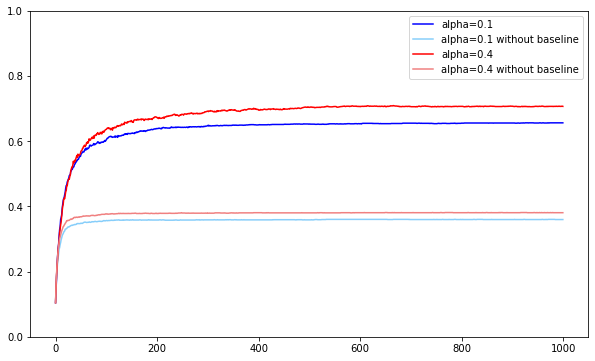

In [19]:
plt.figure(figsize=(10,6))
plt.ylim([0,1])
plt.plot(ac_sft_4_baseline, 'b', label='alpha=0.1')
plt.plot(ac_sft_4, 'lightskyblue', label='alpha=0.1 without baseline')
plt.plot(ac_sft_1_baseline, 'r', label='alpha=0.4')
plt.plot(ac_sft_1, 'lightcoral', label='alpha=0.4 without baseline')
plt.legend() 
plt.show()

## Associative Search (Contextual Bandits)

In **nonassociative tasks**, there is no need to associate different actions with different situations. In these tasks the learner either tries to find a single best action when the task is stationary, or tries to track the best action as it changes over time when the task is nonstationary.

***Associative search task*** involves both trial-and-error learning to search for the best actions, and association of these actions with the situations in which they are best. Associative search tasks are often called _contextual bandits_.

Associative search tasks are intermediate between the k-armed bandit problem and the full reinforcement learning problem. They are like the full reinforcement learning problem in that they involve learning a policy, but they are also like our version of the k-armed bandit problem in that each action affects only the immediate reward. If actions are allowed to affect the next situation as well as the reward, then we have the full reinforcement learning problem.

## References

+ Reinforcement Learning: An Introduction, Richard S. Sutton and Andrew G. Barto
+ Reinforcement Learning, Phil Winder
+ [Multi-Armed Bandits](http://ethen8181.github.io/machine-learning/bandits/multi_armed_bandits.html#Algorithm-1---Epsilon-Greedy)
+ [Multi-Armed Bandits and Reinforcement Learning](https://towardsdatascience.com/multi-armed-bandits-and-reinforcement-learning-dc9001dcb8da)